## Estimate the parameters and subtract our estimate from the data ##

In this notebook, we'll do a crude estimate of the parameters of the GW150914 source. We'll make the assumption that the system has equal mass component black holes, and neither is spinning. This is a large simplification, but will get us parameters close enough to do a demonstrative signal subtraction.

In [1]:
import sys
!{sys.executable} -m pip install pycbc --no-cache-dir

### Read in the detector data ###

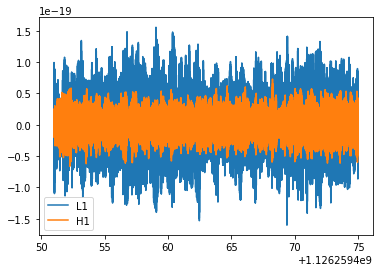

In [2]:
%matplotlib inline
import pylab
from pycbc.frame import read_frame
from pycbc.filter import highpass
from pycbc.catalog import Merger

m = Merger("GW150914")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(m.strain(ifo), 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)

    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()
    pylab.plot(strain[ifo].sample_times, strain[ifo], label=ifo)
pylab.legend()

### Calculate the power spectral density of the data ###

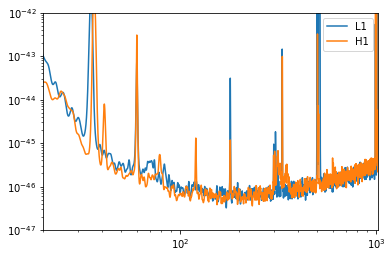

In [4]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psds = {}
for ifo in ['L1', 'H1']:
    # Calculate a psd from the data. We'll use 2s segments in a median - welch style estimate
    # We then interpolate the PSD to the desired frequency step. 
    psds[ifo] = interpolate(strain[ifo].psd(2), stilde[ifo].delta_f)

    # We explicitly control how much data will be corrupted by overwhitening the data later on
    # In this case we choose 2 seconds.
    psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 * strain[ifo].sample_rate),
                                    low_frequency_cutoff=15.0,
                                    trunc_method='hann')

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()

### Let's estimate the mass of the system ###

In [6]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
import numpy

# We will try different component masses and see which gives us the largest 
# Network (quadrature sum between detectors) SNR
masses = numpy.arange(30, 45, .2)

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []
for m in masses:
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    hp, hc = get_fd_waveform(approximant="IMRPhenomD", 
                             mass1=m, mass2=m, 
                             f_lower=20, delta_f=stilde[ifo].delta_f)
    hp.resize(len(stilde[ifo]))
    
    # Matched filter the data and find the peak  
    max_snr, max_time = {}, {}
    for ifo in ['L1', 'H1']:
        snr = matched_filter(hp, stilde[ifo], psd=psds[ifo], low_frequency_cutoff=20.0)
        snr = snr.time_slice(1126259462, 1126259463)
        _, idx = snr.abs_max_loc()
        
        # The complex SNR at the peak
        max_snr[ifo] = snr[idx]
        
        # The time of the peak
        max_time[ifo] = float(idx) / snr.sample_rate + snr.start_time
    
    network_snr = (abs(numpy.array(list(max_snr.values()))) ** 2.0).sum() ** 0.5
    snrs.append(max_snr)
    
    # Keep track of only the loudest peak
    if network_snr > nsnr:
        tmax, hmax, mmax, smax = max_time, hp, m, max_snr
        nsnr = network_snr
    
# See the SNR as a function of the component mass. Notice where this peaks as it gives us
# an estimate of what the parameters of the source system are. Note that masses
# here are in the *detector* frame, so if the source is located far away, it will in
# fact correspond to a lighter system due to cosmological redshift.
print("We found the best Mass1=Mass2 was %s solar masses (detector frame)" % mmax)

We found the best Mass1=Mass2 was 35.99999999999998 solar masses (detector frame)


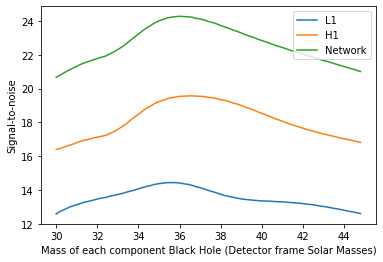

In [8]:
# We can see how the estimate from each IFO agrees
import numpy

network_snrs = [abs(numpy.array(list(s.values()))**2.0).sum()**0.5 for s in snrs]
for ifo in ['L1', 'H1']:
    ind_snrs =  [abs(s[ifo]) for s in snrs]
    pylab.plot(masses, ind_snrs, label=ifo)
    
pylab.plot(masses, network_snrs, label='Network')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Mass of each component Black Hole (Detector frame Solar Masses)')
pylab.legend()

### We'll see what's already in the data first ###

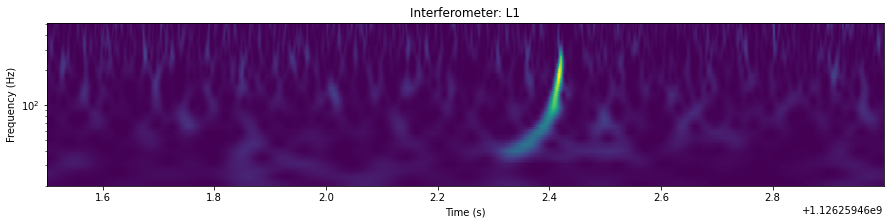

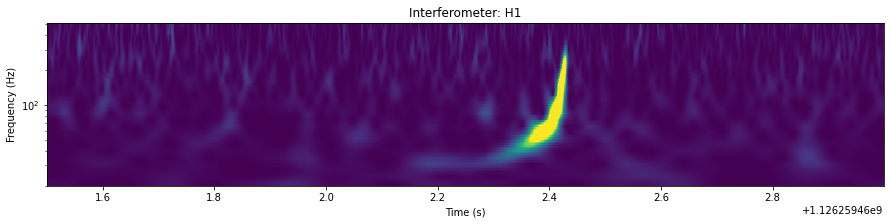

In [9]:
for ifo in ['L1', 'H1']:
    # Whiten the data
    hoft = (stilde[ifo] / psds[ifo] ** 0.5).to_timeseries()

    # Select the time around the event
    zoom = hoft.time_slice(1126259461.5, 1126259463)

    # Calculate the qtransform (a kind of time-frequency representation similar to a spectrogram)
    times, freqs, power = zoom.qtransform(.001, logfsteps=100, frange=(20, 512), qrange=(8, 8))

    pylab.figure(figsize=(15,3))
    pylab.pcolormesh(times, freqs, power, vmin=0, vmax=50)
    pylab.ylim(20, 512)
    pylab.title('Interferometer: %s' % ifo)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(times.min(), times.max())
    pylab.yscale('log')

### Now we subtract the template we found from the data and see what's left###

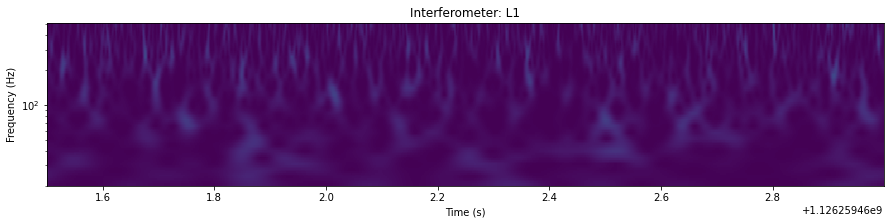

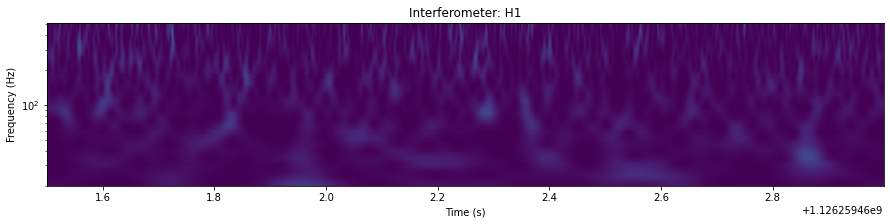

In [10]:
from pycbc.filter import sigma

for ifo in ['L1', 'H1']:
    # Shift the template to the maximum time at this sample rate
    dt =  tmax[ifo] - stilde[ifo].start_time
    inj = hmax.cyclic_time_shift(dt)

    # Scale the template to the SNR and phase
    inj /= sigma(hmax, psd=psds[ifo], low_frequency_cutoff=20.0)
    inj *= smax[ifo]

    # Subtract from the data
    stilde2 = stilde[ifo] - inj

    # Whiten the data
    hoft = (stilde2 / psds[ifo] ** 0.5).to_timeseries()

    # display the time around the event
    zoom = hoft.time_slice(1126259461.5, 1126259463)
    times, freqs, power = zoom.qtransform(.001, logfsteps=100, frange=(20, 512), qrange=(8, 8))

    # Now let's see what the time-frequency space looks like? 
    # You can see that the signal is largely removed from the data
    # and the time appears similar to the surrounding data.  
    pylab.figure(figsize=(15,3))
    pylab.pcolormesh(times, freqs, power, vmin=0, vmax=50)
    pylab.ylim(20, 512)
    pylab.title('Interferometer: %s' % ifo)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(times.min(), times.max())
    pylab.yscale('log')

# Note that a better match to the data can be found if you allow more
# freedom in the possible source parameters than we
# have here.